![terrainbento logo](../images/terrainbento_logo.png)


# Introduction to the terrainbento output writers.


## Overview
This tutorial shows example usage of the terrainbento boundary handlers. For comprehensive information about all options and defaults, refer to the [documentation](http://terrainbento.readthedocs.io/en/latest/). 

## Prerequisites
This tutorial assumes you have at least skimmed the [terrainbento manuscript](https://www.geosci-model-dev.net/12/1267/2019/) and worked through the [Introduction to terrainbento](http://localhost:8888/notebooks/example_usage/Introduction_to_terrainbento.ipynb) tutorial.


### terrainbento output writers

By default terrainbento will save a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file at equal intervals specified by the ``output_interval`` parameter. For many applications it may be sufficient to run a model, save output, and then open the stack of NetCDFs for postprocessing (we recommend [xarray](http://xarray.pydata.org/en/stable/) and [holoviews](http://holoviews.org) for opening, analyzing, and plotting stacks of NetCDFs in python). The default NetCDF writer can be turned off by passing ``output_default_netcdf=False`` to the model constructor.

If in your application, you want to have additional output written at the ``output_interval`` intervals, you can pass any number of functions or classes that write this ouput to terrainbento. These functions and classes are called **output writers**. There is no limit to what you can do with the output writers. You could use them to make plots to turn into an animation, write diagnostic information about model run time, or calculate an objective function value over time. If you want multiple writers with independent output intervals and/or some file management functions, you will benefit from using **advanced output writers**. The only restriction with advanced output writers is that output times must occur on normal model steps (i.e. a multiple of the model step).

To make the output writers support as many possible use cases, terrainbento was designed to take any combination and number of function, class, and advanced output writers.

### Reference material
If you are not familiar with user defined python functions, consider reviewing [this tutorial](https://www.datacamp.com/community/tutorials/functions-python-tutorial#udf). If you are not familiar with user defined python classes, consider referring to [this tutorial](https://www.digitalocean.com/community/tutorials/how-to-construct-classes-and-define-objects-in-python-3).


## Example Usage

To begin, we will import the required python modules. 

In [1]:
import numpy as np
np.random.seed(42)

import os
import glob
import re

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # Used to suppress Deprecation warnings. Not essential for your model.

from landlab.components import DrainageDensity
from landlab import imshow_grid

from terrainbento import Basic

# The following is for advanced output writers and isn't necessary for basic usage.
from terrainbento.output_writers import GenericOutputWriter, StaticIntervalOutputWriter

### Function output writers
We begin by creating an example user-defined output writer function. When a terrainbento model runs the `OutputWriter` function, it will pass the model instance to the output writer. Thus the output writer function must be able to make all required calculations and plots based on the model instance. It is almost always the case that a user will want to write some sort of output -- typically a text file or plot -- each time the output writer is run. 

A user has the option of appending the output writer output to a file or using the model attributes `model.model_time` or `model.iteration` in the output file name to distinguish it from other files.  



In [2]:
def name_of_output_writer_function(model):
    # put lines of code here that use the model object to calculate outputs
    # for example, mean elevation
    val = model.z.mean()

    # write output, option 1: unique files per timestep
    with open('name_of_file.' + str(int(model.iteration)) + '.txt', 'w') as f:
        f.write(str(val))

    # write output, option 2: append values to same file
    with open('name_of_file.txt', 'a') as f:
        f.write(
            str(model.iteration) + ', ' + str(model.model_time) + ', ' +
            str(val) + '\n')

Here we will define an output writer called `write_drainage_density`. Not surprisingly, it calculates and writes out the drainage density of a model domain. The **DrainageDensity** component has two options for identifying where channels are located -- either a user-specified channel mask or a slope-area threshold. We will use this latter option. 

In [3]:
def write_drainage_density(model):
    dd = DrainageDensity(model.grid,
                         area_coefficient=0.1,
                         slope_coefficient=1.0,
                         area_exponent=0.5,
                         slope_exponent=0.6,
                         channelization_threshold=0.35)
    mean_drainage_density = dd.calculate_drainage_density()
    if np.isinf(mean_drainage_density):
        mean_drainage_density = 0.0
    fname = 'drainage_density.txt'
    if os.path.exists(fname) is False:
        with open(fname, 'w') as f:
            f.write('model_time,drainage_density\n')

    with open(fname, 'a') as f:
        f.write(
            str(model.model_time) + ', ' + str(mean_drainage_density) + '\n')

    del dd

Next we construct the parameter dictionary we will use to run the model. 

In [4]:
basic_params = {
    # create the Clock.
    "clock": {
        "start": 0,
        "step": 1000,
        "stop": 2e5
    },

    # Create the Grid
    "grid": {
        "RasterModelGrid": [
            (25, 40),
            {
                "xy_spacing": 40
            },
            {
                "fields": {
                    "node": {
                        "topographic__elevation": {
                            "random": [{
                                "where": "CORE_NODE"
                            }]
                        }
                    }
                }
            },
        ]
    },

    # Set up Boundary Handlers
    "boundary_handlers": {
        "NotCoreNodeBaselevelHandler": {
            "modify_core_nodes": True,
            "lowering_rate": -0.0005
        }
    },
    # Parameters that control output.
    "output_interval": 1e3,
    "save_first_timestep": True,
    "output_prefix": "model_basic_output_intro_ow1",
    "fields": ["topographic__elevation"],

    # Parameters that control process and rates.
    "water_erodibility": 0.001,
    "m_sp": 0.5,
    "n_sp": 1.0,
    "regolith_transport_parameter": 0.1,
}

Unline the boundary handlers described in [this tutorial](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb), we pass the output writer to terrainbento as a keyword argument. 

After instantiating the model, we run it. 

In [5]:
basic = Basic.from_dict(basic_params,
                        output_writers={"function": [write_drainage_density]})
basic.run()

/home/alex/hacking/landlab_for_paragem/landlab/components/drainage_density/drainage_density.py:449: RuntimeWarning: divide by zero encountered in double_scalars
  self._grid.core_nodes


First we will make a plot of the topography. We have evolved some nice valleys and ridges. 

/home/alex/hacking/landlab_for_paragem/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/home/alex/hacking/landlab_for_paragem/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


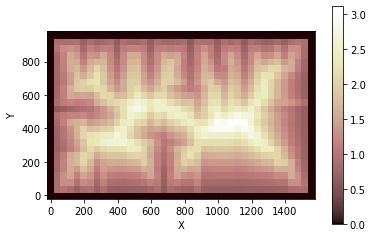

In [6]:
imshow_grid(basic.grid, basic.z)

Next we plot the channel mask from the last timestep. It is stored in an at-node grid field called `chanel__mask`.

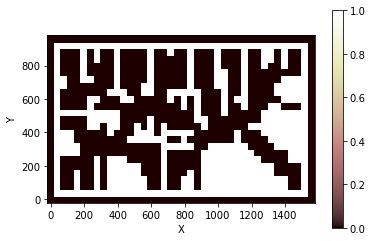

In [7]:
channel__mask = basic.grid.at_node['channel__mask'].astype(int)
imshow_grid(basic.grid, channel__mask)

Our mask identifies the channel areas. 

Next we will read in the output we wrote to the file `drainage_density.txt` using [pandas](https://pandas.pydata.org) and remove the files created by running the model. In your usage you probably won't want to remove these files, but we are doing it so that running the model won't create lots of files in your directory. 

In [8]:
df = pd.read_csv('drainage_density.txt')
basic.remove_output_netcdfs()
os.remove('drainage_density.txt')

We can look at what is inside of the dataframe. 

In [9]:
df.head()

,model_time,drainage_density
0,0.0,0.000000
1,1000.0,0.014413
2,2000.0,0.009634
3,3000.0,0.007683
4,4000.0,0.007832


In [10]:
df.columns

Index(['model_time', 'drainage_density'], dtype='object')

This dataframe shows us the history of drainage density through time. Next we will plot it. 

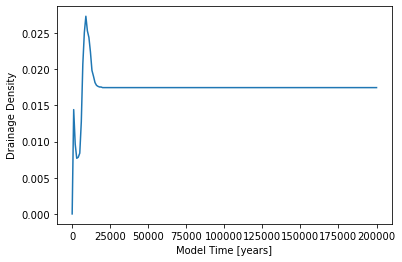

In [11]:
plt.figure()
plt.plot(df.model_time, df.drainage_density)
plt.xlabel('Model Time [years]')
plt.ylabel('Drainage Density')
plt.show()

### Using a class instead of a function

terrainbento can support output writer classes. The simplest form of output class needs to look something like the following.

In [12]:
class my_ouput_writer_class(object):
    def __init__(self, model):
        # save the model to the output writer class
        self.model = model
        # do whatever else you want to do here:
    def run_one_step(self):
        # make calculations

        # write something out based on the calculations.
        # we recommend including the model time as a part of
        # the filename so that it is possible to identify
        # what time each file is associated with

        pass  # remove this line when you modify this example.

You might ask: when is an output writer class more appropriate than a function? The answer is that if you can calculate everything you need from the model instance at a given timestep, you probably can just use a function. However, if you need information from past timesteps, you'll need to use a class. 

For example, here we will use a simple example in which the output writer writes out the mean and maximum elevation averaged over a few timesteps. We could not do this with a function. 

In [13]:
class time_averaged_elevation(object):
    def __init__(self, model):
        self.model = model
        self.model_time = []
        self.model_mean_elevation = []
        self.model_max_elevation = []

    def run_one_step(self):
        self.model_time.append(self.model.model_time)
        self.model_mean_elevation.append(
            self.model.z[self.model.grid.core_nodes].mean())
        self.model_max_elevation.append(
            self.model.z[self.model.grid.core_nodes].max())
        if len(self.model_time) >= 5:
            with open(
                    'time_averaged_elevation.' +
                    str(int(self.model.model_time)) + '.txt', 'w') as f:
                f.write(str(np.mean(self.model_mean_elevation[-5:])) + '\n')
                f.write(str(np.mean(self.model_max_elevation[-5:])) + '\n')

Next we run the model with the new output writer. Note that if you want to use more than one output writer you can just provide a list of functions and classes. 

In [14]:
basic_params = {
    # create the Clock.
    "clock": {
        "start": 0,
        "step": 1000,
        "stop": 2e5
    },

    # Create the Grid
    "grid": {
        "RasterModelGrid": [
            (25, 40),
            {
                "xy_spacing": 40
            },
            {
                "fields": {
                    "node": {
                        "topographic__elevation": {
                            "random": [{
                                "where": "CORE_NODE"
                            }]
                        }
                    }
                }
            },
        ]
    },

    # Set up Boundary Handlers
    "boundary_handlers": {
        "NotCoreNodeBaselevelHandler": {
            "modify_core_nodes": True,
            "lowering_rate": -0.0005
        }
    },
    # Parameters that control output.
    "output_interval": 1e3,
    "save_first_timestep": True,
    "output_prefix": "model_basic_output_intro_ow2",
    "fields": ["topographic__elevation"],

    # Parameters that control process and rates.
    "water_erodibility": 0.001,
    "m_sp": 0.5,
    "n_sp": 1.0,
    "regolith_transport_parameter": 0.1,
}

basic = Basic.from_dict(basic_params,
                        output_writers={
                            "function": [write_drainage_density],
                            "class": [time_averaged_elevation]
                        })

basic.run()

/home/alex/hacking/landlab_for_paragem/landlab/components/drainage_density/drainage_density.py:449: RuntimeWarning: divide by zero encountered in double_scalars
  self._grid.core_nodes


Now that we've run the model we will compile all of the output into a dataframe and plot it. 

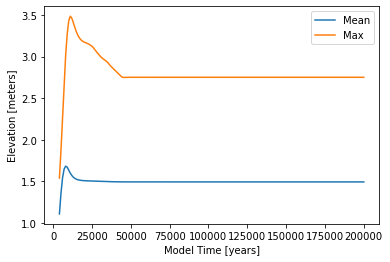

In [15]:
output_files = glob.glob('time_averaged_elevation.*.txt')
temp = {}
for of in output_files:
    with open(of, 'r') as f:
        model_time = int(of.split('.')[-2])
        mean_elev = float(f.readline())
        max_elev = float(f.readline())
        temp[model_time] = {
            'mean_elevation': mean_elev,
            "max_elevation": max_elev
        }
    os.remove(of)
df = pd.DataFrame(temp).T
df = df.sort_index()

basic.remove_output_netcdfs()
os.remove('drainage_density.txt')

plt.figure()
plt.plot(df.index.values, df.mean_elevation, label='Mean')
plt.plot(df.index.values, df.max_elevation, label='Max')
plt.legend()
plt.xlabel('Model Time [years]')
plt.ylabel('Elevation [meters]')
plt.show()

In [16]:
df.head()

,mean_elevation,max_elevation
4000,1.106317,1.537228
5000,1.353691,1.870489
6000,1.539310,2.259353
7000,1.644352,2.663759
8000,1.681238,3.010681


### Using advanced output classes
The output function and class methods shown above only work with the single ``output_interval`` argument provided to the model. If you want better control of when to write output, your output writer class should inherit GenericOutputWriter or, more likely, StaticIntervalOutputWriter.

GenericOutputWriter is the base class for all output writers and provides the common interface functions for the model to interact with. Output times are controlled by providing the generic class an iterator of output times either via the constructor or by calling ``register_times_iter`` any time before starting the model run. The iterator can be any sequence of (mostly) monotonically increasing floats and the generic class will automatically restrict times to the clock stop time (for infinite iterators). Inheriting GenericOutputWriter is the best option if you want to use unusual output times (e.g. output on a log scale or output times based on map conditions).

StaticIntervalOutputWriter will be the better choice for most use cases. You tell it what interval or predetermined output times you want, and it handles all the iterator business under the hood.

Like the simple class ouptut writers above, your inheritting class needs to define ``run_one_step`` to make the actual output. Unlike the simple class output writers, all advanced output writers have access to the ``filename_prefix`` property which strings together the model's prefix, output writer's name, and the output time so you can easily generate meaningful standardized filenames. Additionally, every time you make a file, you can register the new file with ``register_output_filepath`` in order to use some convenient file management functions.

Your class should have a form similar to:

In [17]:
class my_advanced_ouput_writer_class(StaticIntervalOutputWriter):
    def __init__(self, model, **static_interval_kwargs):
        # Call the StaticIntervalOutputWriter constructor and pass all the kwargs
        # The important kwargs are "name" and "intervals" or "times"
        super().__init__(model, **static_interval_kwargs)

        # do whatever else you want to do here
        
    def run_one_step(self):
        # make calculations if applicable

        # write something out based on the calculations.
        # self.filename_prefix includes the model time, but if 
        # you use your own, we recommend including the model time 
        # as a part of the filename so that it is possible to 
        # identify what time each file is associated with
        
        # Call self.register_output_filepath(new_filepath) if desired
        
        pass  # remove this line when you modify this example.

#### The two most important keyword arguments for StaticIntervalOutputWriter are ``intervals`` and ``times``. Do not define both when calling the constructor.

``intervals`` can be either a single float value or a list of float values that represent a uniform interval between outputs or a repeating sequence of intervals between output, respectively. Providing a single float interval behaves the same as the earlier function/class output writers with the model's ``output_interval`` argument, except that each writer can have its own interval. Single intervals and interval lists are repeated automatically.

``times`` can be a single float or a list of floats that represent one or more predetermined output times.

You can force the writer to output on the first (i.e. initial conditions) and last step by passing ``save_first_step=True`` and ``save_last_step=True``, respectively, regardless of whether ``intervals`` or ``times`` would normally include those two times. Default behavior saves the last step but not the first step.

``name`` is used both for identifying the writer and for generating filename prefixes. Default names are provided, but won't be very specific.

We will create three classes below to highlight some of the timing features of advanced output writers. They will plot the mean, max, and min of the topographic elevation at different interval times. I show the parameter dictionary definition below the class but not actually run the code until later.

Let's start with what will probably be the most common use case: simple uniform intervals.

In [18]:
class UniformIntervalsExample(StaticIntervalOutputWriter):
    def __init__(self, model, **static_interval_kwargs): 
        super().__init__(model, **static_interval_kwargs)
        
    def run_one_step(self):
        # Calculate the mean elevation
        z = self.model.z[self.model.grid.core_nodes]
        mean_elevation = z.mean()

        # Save the data to a file
        filename = f"{self.filename_prefix}.txt"
        filepath = self.make_filepath(filename)
        with open(filepath, 'w') as f:
            f.write(str(mean_elevation) + '\n')
            
        # Register the new filepath
        self.register_output_filepath(filepath)

# Here is the dictionary entry for this writer:
# Note: 'uniform-intervals' becomes the name of the writer.
# output_writers_params = {
#     ...
#     'uniform-intervals': {
#         'class': UniformIntervalsExample,
#         'kwargs': {
#             'intervals':5000,
#         }
#     },
#     ...
# }

Now let's define an output writer that will alternate intervals. In this case, I want to output with a one-two punch cadence, so the output times will be: 0, 1e3, 10e3, 11e3, 20e3, 21e3, 30e3, 31e3, ...
Note that 0 will be produced only because ``save_first_timestep`` will be ``True``. 

The definition is mostly the same as UniformIntervalsExample, but I set a different default name and write a different value. If it weren't for the different output, they could have easily been the same class with different values passed to the constructor (including name).

In [19]:
class RepeatingIntervalsExample(StaticIntervalOutputWriter):
    def __init__(self, model, **static_interval_kwargs):
        super().__init__(model, **static_interval_kwargs)
        
    def run_one_step(self):
        # Calculate the max elevation
        z = self.model.z[self.model.grid.core_nodes]
        max_elevation = z.max()
        
        # Save the data to a file
        filename = f"{self.filename_prefix}.txt"
        filepath = self.make_filepath(filename)
        with open(filepath, 'w') as f:
            f.write(str(max_elevation) + '\n')
            
        # Register the new filepath
        self.register_output_filepath(filepath)

# Here is the dictionary entry for this writer:
# Note: 'repeating-intervals' becomes the name of the writer.
# output_writers_params = {
#     ...
#     'repeating-intervals': {
#         'class': RepeatingIntervalsExample,
#         'kwargs': {
#             'intervals':[1000,9000],
#         }
#     },
#     ...
# }

Let's also define an output writer which uses it's own custom iterator. In this example, the output times will roughly follow a log scale where it ouputs 9 evenly spaced values for each power of 10 indefinitely.

In [20]:
class CustomIterExample(GenericOutputWriter):
    def __init__(self, model, init_power=0, **generic_kwargs):
        super().__init__(model, **generic_kwargs)
        
        # Create the log iterator starting with the provided initial power
        # Ex. init_power=1 yields 10.0 as the first value
        log_iter = self.log_fu(init_power)
        
        # Register the iter
        self.register_times_iter(log_iter)
    
    def log_fu(self, power=0):
        # Define an infinite iterator that generates 9 values for each power of ten.
        # Can pick a different starting power by passing something other than zero
        # e.g. log_fu(1) will generate floats for:
        #     10, 20, 30, 40, 50, 60, 70, 80, 90,
        #     100, 200, 300, 400, 500, 600, 700, 800, 900,
        #     1000, 2000, 3000, ...
        while True:
            for i in range(1,10):
                yield 10.0**power * i
            power += 1
                
    def run_one_step(self):
        # Calculate the min elevation
        z = self.model.z[self.model.grid.core_nodes]
        min_elevation = z.min()

        # Save the data to a file
        filename = f"{self.filename_prefix}.txt"
        filepath = self.make_filepath(filename)
        with open(filepath, 'w') as f:
            f.write(str(min_elevation) + '\n')
            
        # Register the new filepath
        self.register_output_filepath(filepath)

# Here is the dictionary entry for this writer:
# Note: 'log-intervals' becomes the name of the writer.
# output_writers_params = {
#     ...
#     'log-intervals': {
#         'class': CustomIterExample,
#         'kwargs': {
#             'init_power':3,
#         }
#     },
#     ...
# }

Now we will define the general parameters for the model.

In [21]:
basic_params = {
    # create the Clock.
    "clock": {
        "start": 0,
        "step": 1000,
        "stop": 2e5,
    },

    # Create the Grid
    "grid": {
        "RasterModelGrid": [
            (25, 40),
            {
                "xy_spacing": 40
            },
            {
                "fields": {
                    "node": {
                        "topographic__elevation": {
                            "random": [{
                                "where": "CORE_NODE"
                            }]
                        }
                    }
                }
            },
        ]
    },

    # Set up Boundary Handlers
    "boundary_handlers": {
        "NotCoreNodeBaselevelHandler": {
            "modify_core_nodes": True,
            "lowering_rate": -0.0005
        }
    },
    # Parameters that control output.
    #"output_interval": 1e3, # Not used for these examples
    "save_first_timestep": True,
    "save_last_timestep": True,
    "output_prefix": "model_basic_output_intro_ow3",
    "fields": ["topographic__elevation"],

    # Parameters that control process and rates.
    "water_erodibility": 0.001,
    "m_sp": 0.5,
    "n_sp": 1.0,
    "regolith_transport_parameter": 0.1,
}

Now we define output writer dictionary with all the writer parameters.

In [22]:
output_writers_params = {
    'uniform-intervals': {
        'class': UniformIntervalsExample,
        'kwargs': {
            'intervals':5000,
        }
    },
    'repeating-intervals': {
        'class': RepeatingIntervalsExample,
        'kwargs': {
            'intervals':[1000,9000],
        }
    },
    'log-intervals': {
        'class': CustomIterExample,
        'kwargs': {
            'init_power':3,
        }
    },
}

Now we will initialize the model and run it.

In [23]:
basic = Basic.from_dict(basic_params, output_writers=output_writers_params)
basic.run()

Now we will read the output file and generate a plot showing the data. Read the next markdown cell for more info about the resulting plots.

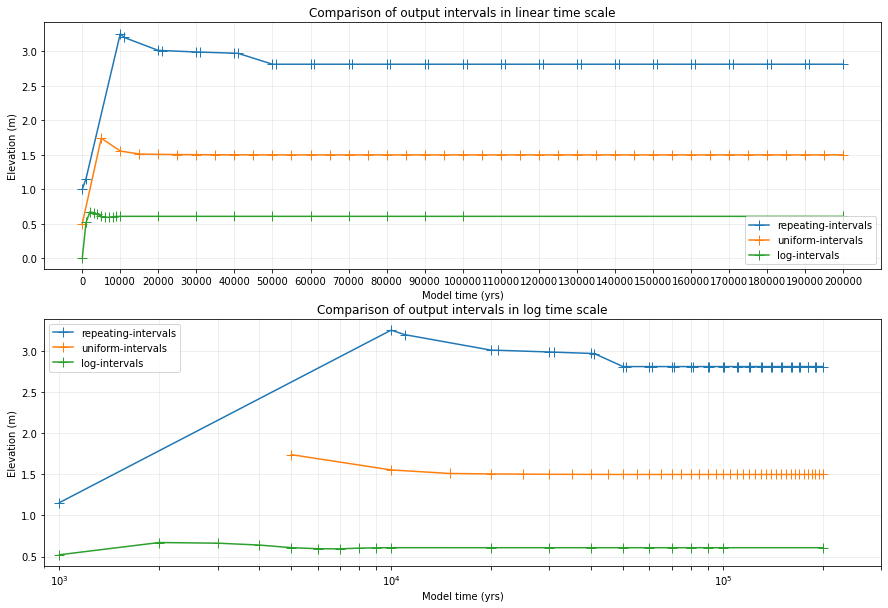

In [24]:
# Define a function to read all the txt filepaths from a writer
# Return the data in a Pandas Dataframe
def read_filepaths(ow_name):
    filepaths = basic.get_output(extension='txt', writer=ow_name)

    data_dict = {}
    for fp in filepaths:
        time_str = re.search('time-\d+\.\d+', fp)[0]
        model_time = float(time_str[5:])
        with open(fp, 'r') as f:
            value = float(f.readline())
            data_dict[model_time] = {ow_name: value}
            
    df = pd.DataFrame(data_dict).T
    df.index.name = 'Model time (yrs)'
    
    return df

# Now read the data from the three writers and concatenate them into one large dataframe
ow_names = ['repeating-intervals', 'uniform-intervals', 'log-intervals']
frames = []
for name in ow_names:
    frames.append(read_filepaths(name))
data = pd.concat(frames)

# Clean up the files now that we have read the data.
basic.remove_output()

# Create the figure.
fig, axes = plt.subplots(2, 1, figsize=(15,10))
ax1, ax2 = axes

# Plot the data.
# Pandas plotting has a minor bug which throws matplotlib deprecation warnings. Ignore them.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=mpl.MatplotlibDeprecationWarning)
    data.plot(ax=ax1, marker='+', markersize=10)
    data[data.index > 0].plot(ax=ax2, marker='+', markersize=10, logx=True)


# Format the linear scale plot
ax1.set_title("Comparison of output intervals in linear time scale")
ax1.grid(alpha=0.25)
ax1.set_xticks(range(0, 2*10**5+1, 10**4))
ax1.set_ylabel("Elevation (m)")

# Format the log scale plot
ax2.set_title("Comparison of output intervals in log time scale")
ax2.grid(alpha=0.25)
ax2.set_xticks([i*10**p for p in [3,4,5] for i in [1,2,3,4,5,6,7,8,9]])
ax2.set_xlim((0.9*10**3, 300*10**3))
ax2.set_ylabel("Elevation (m)")

plt.show()

The first plot shows the repeating and uniform intervals nicely and the second plot shows the log intervals nicely (t=0 is ignored for log plot).

While the actual data in these plots are not very useful, the key aspect here is <i>when</i> the output writers generated output. The advanced output writers can have independent and arbitrary output times. The only restriction (a design decision, not an actual computational limit) is that times must occur on a normal model step.

## Next Steps

- We recommend you review the [terrainbento manuscript](https://www.geosci-model-dev.net/12/1267/2019/).

- There are three additional introductory tutorials: 

    1) [Introduction terrainbento](Introduction_to_terrainbento.ipynb) 
    
    2) [Introduction to boundary conditions in terrainbento](introduction_to_boundary_conditions.ipynb)
    
    3) **This Notebook**: [Introduction to output writers in terrainbento](introduction_to_output_writers.ipynb). 
    
    
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:

    1) [Basic](../coupled_process_elements/model_basic_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

    2) [BasicVm](../coupled_process_elements/model_basic_var_m_steady_solution.ipynb) which permits the drainage area exponent to change

    3) [BasicCh](../coupled_process_elements/model_basicCh_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law

    4) [BasicVs](../coupled_process_elements/model_basicVs_steady_solution.ipynb) which uses variable source area hydrology

    5) [BasisRt](../coupled_process_elements/model_basicRt_steady_solution.ipynb) which allows for two lithologies with different K values